In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
labels_title = ["Paice/Husk", "Krovetz", "S-Stripping", "Porter2", "Lovins", "Wikt", "None"]
collection_n_values = [1,2,4,8,16,32,64]
# collection_sizes = [52342886, 26171443, 13085721, 6542860, 3271430, 1635715, 817857]
collection_sizes = [51638042, 25818901, 12909723, 6454615, 3227227, 1613766, 806826]

home_dir = "/home/harka424/Documents/COSC490/Stemming"
data_dir_clueweb = path.join(home_dir, "Data/clueweb")
data_dir_wikt = path.join(home_dir, "Data/wikt")
fig_dir = '/home/harka424/Documents/COSC490/cosc490_report/figures'

MARKERS = ["o","^","s","*","d", "P", "X"]

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Preparing Data

In [3]:
df_list = list()

for n in collection_n_values:
   df = pd.read_csv(path.join(data_dir_clueweb,f"collectionSize/ndcg_{n}"), sep=" ")
   df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

data_avg = data[data["qid"] == "amean"]
data = data.drop(data[data["qid"] == "amean"].index)


### Overall nDCG

In [4]:
best_nDCG = list()
for size in collection_sizes:
    selected_data = data_avg[data_avg["collectionSize"] == size]
    best_nDCG.append(selected_data["ndcg"].max())

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


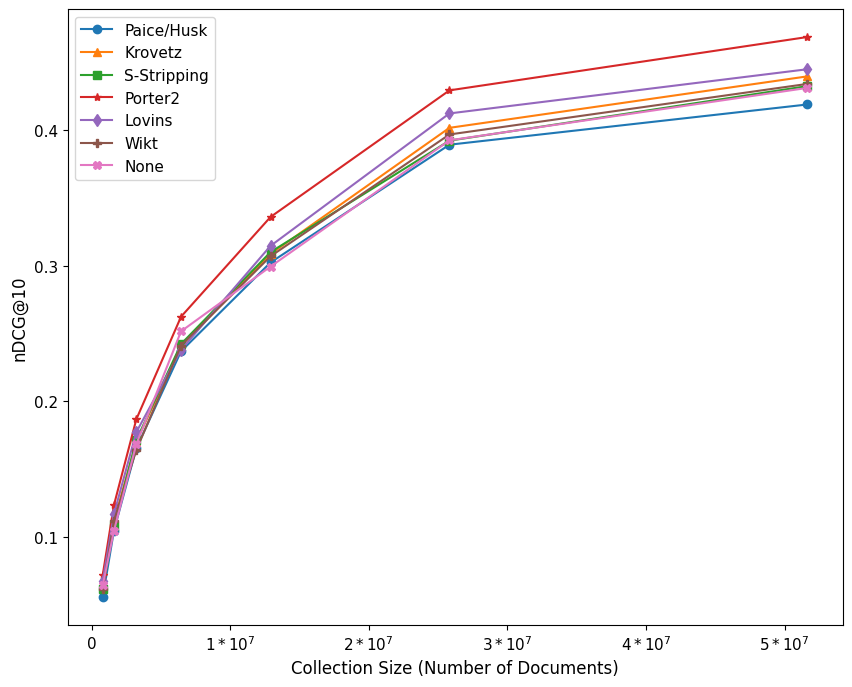

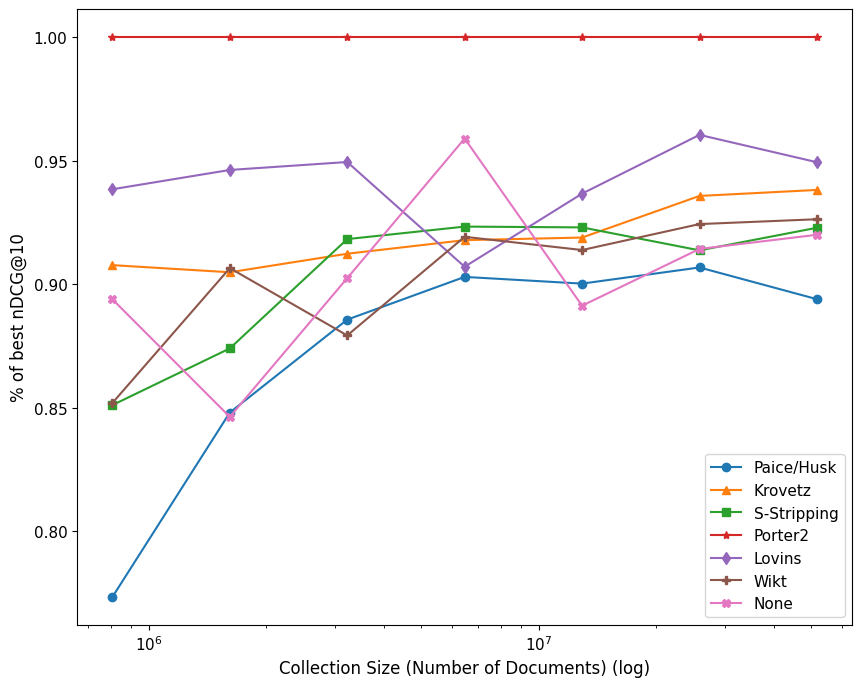

In [5]:
marker = itertools.cycle(MARKERS)

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["collectionSize"], stemmer_data["ndcg"], marker=next(marker), label=stemmer)
    
# plt.title("nDCG@10 vs Collection Size")
plt.xlabel("Collection Size (Number of Documents)")
plt.ylabel("nDCG@10")
plt.legend(labels=labels_title)
# plt.ticklabel_format(axis="x",style="plain")
plt.xticks([0,  10000000,  20000000,  30000000, 40000000,  50000000],["$0$", "$1*10^7$", "$2*10^7$", "$3*10^7$", "$4*10^7$", "$5*10^7$"])
plt.savefig(f"{fig_dir}/figure8.eps",dpi=1200,bbox_inches='tight')

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["ndcg"])/best_nDCG
    plt.plot(stemmer_data["collectionSize"], stemmer_values, marker=next(marker), label=stemmer)
    plt.xscale("log")

# plt.title("nDCG@10 Relative to Best vs Collection Size")
plt.xlabel("Collection Size (Number of Documents) (log)")
plt.ylabel("% of best nDCG@10")
plt.legend(labels=labels_title)
plt.savefig(f"{fig_dir}/figure9.eps",dpi=1200,bbox_inches='tight')

### Linguistic Accuracy

In [6]:
ndcg_fmeasure = data_avg[data_avg["stemmer"] != "none"]
ndcg_fmeasure = ndcg_fmeasure[ndcg_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for size in collection_sizes:
    fmeasures.extend(averages)
ndcg_fmeasure = ndcg_fmeasure.assign(fmeasure=fmeasures)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


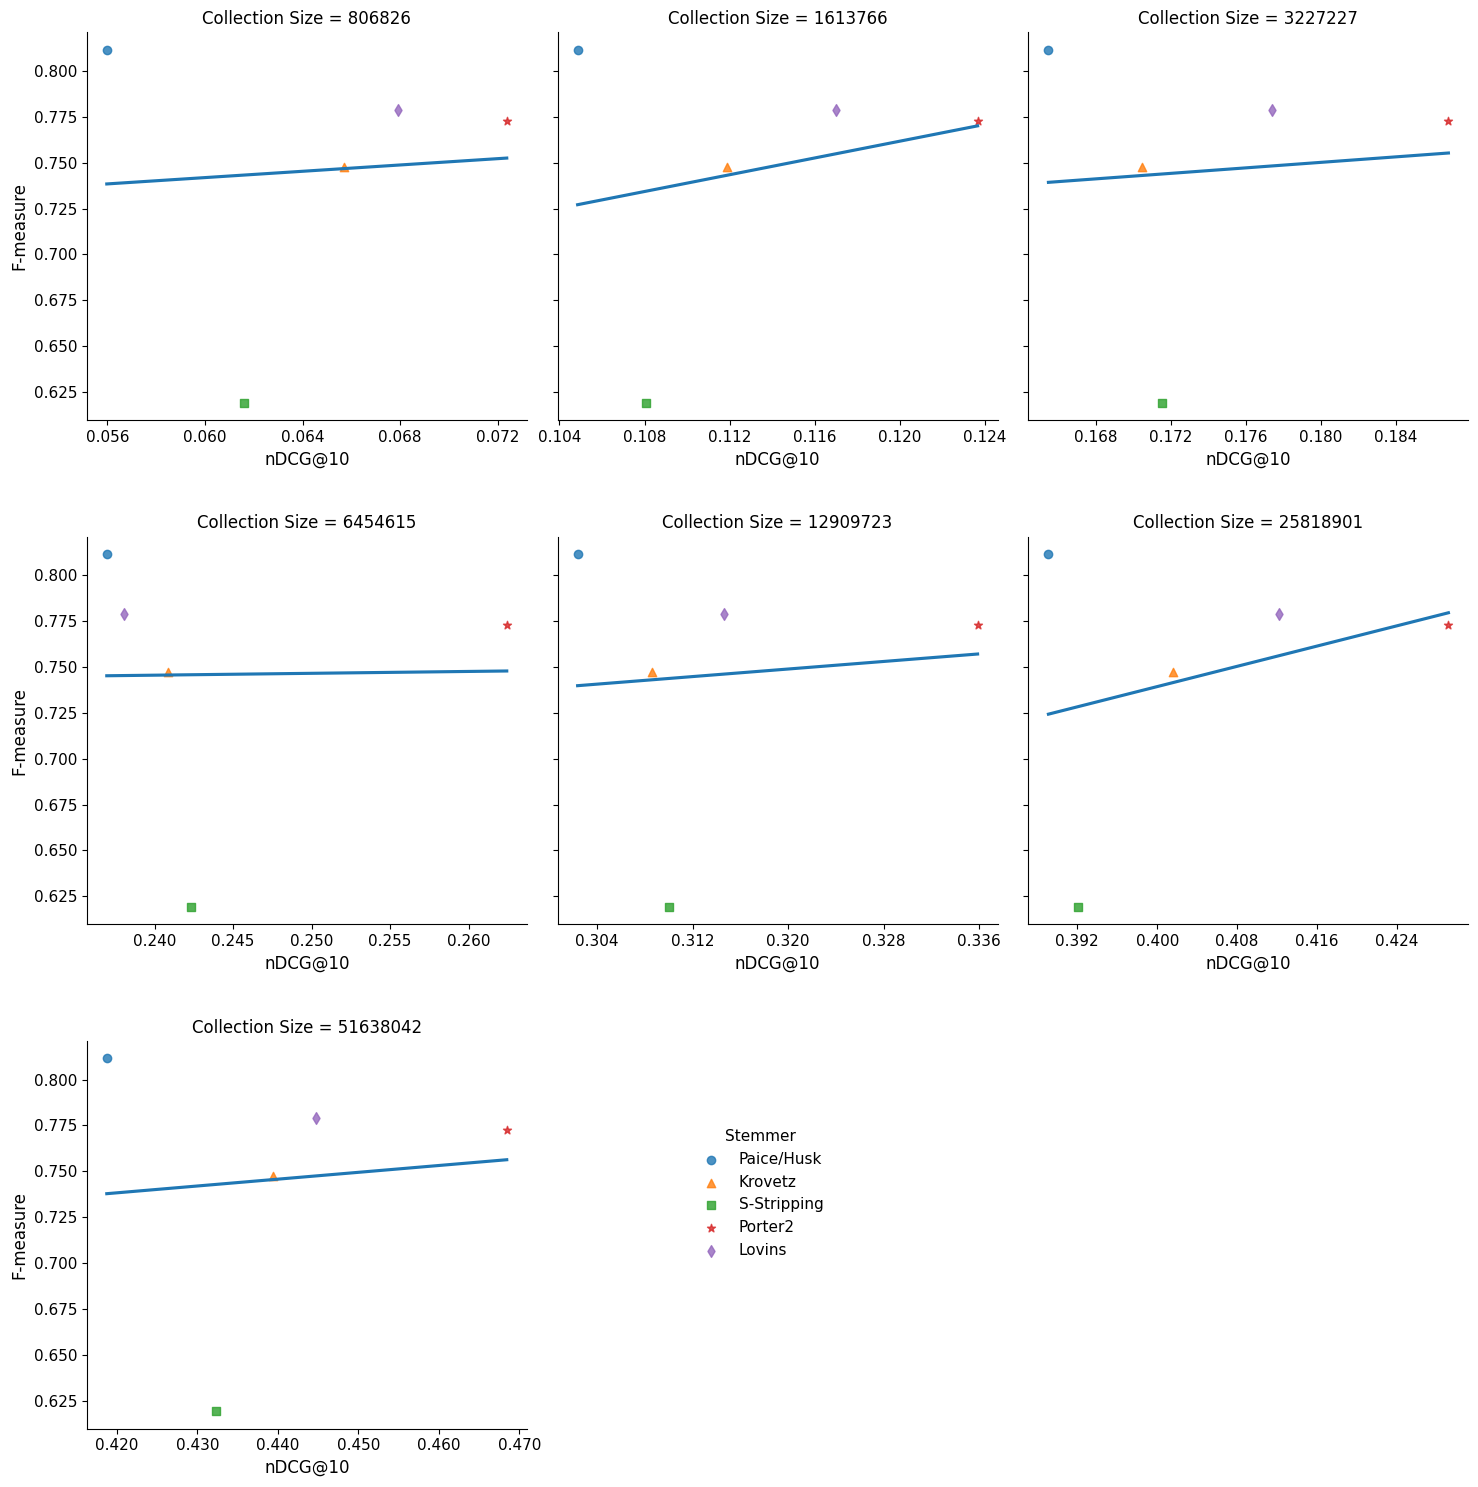

In [8]:
graph = sns.lmplot(ndcg_fmeasure, x="ndcg", y="fmeasure", hue="stemmer", markers=MARKERS[:-2], col="collectionSize", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False, legend=False)
graph.set_titles(col_template="Collection Size = {col_name}")

for size, ax in zip(np.unique(data_avg["collectionSize"]), graph.axes):
    target_data = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]
    sns.regplot(target_data, x="ndcg", y="fmeasure", scatter=False, ci=None, ax=ax)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.3f"))
graph.set(ylabel="F-measure",xlabel="nDCG@10")
graph.add_legend(title="Stemmer",labels=labels_title[:-2],bbox_to_anchor=(0.52,0.2))
plt.subplots_adjust(hspace=0.3)
plt.savefig(f"{fig_dir}/figure12.eps",dpi=1200,bbox_inches='tight')
plt.show()

In [23]:
print("size pearson-R p-value")
for size in reversed(collection_sizes):
    x = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]["ndcg"].to_numpy()
    y = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]["fmeasure"].to_numpy()
    print(f"{size} {stats.pearsonr(x,y).statistic:.3f} {stats.pearsonr(x,y).pvalue:.3f}")

size pearson-R p-value
806826 0.072 0.908
1613766 0.229 0.712
3227227 0.082 0.896
6454615 0.014 0.982
12909723 0.089 0.887
25818901 0.303 0.620
51638042 0.092 0.884


### Statistical Significance

In [24]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
806826 1.1581 0.2496
1613766 1.9522 0.0537
3227227 1.8585 0.0661
6454615 0.9586 0.3401
12909723 2.5326 0.0129
25818901 2.4722 0.0151
51638042 2.1703 0.0324


In [25]:
#t-test between paiceHusk (one of the lowest performing) and none
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
806826 -1.1474 0.2540
1613766 0.0189 0.9850
3227227 -0.2481 0.8046
6454615 -1.0278 0.3065
12909723 0.1865 0.8524
25818901 -0.1766 0.8602
51638042 -0.6123 0.5417


In [26]:
#t-test between porter2 and paiceHusk
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
806826 2.3315 0.0218
1613766 2.3912 0.0187
3227227 2.1190 0.0366
6454615 2.1978 0.0303
12909723 2.1858 0.0312
25818901 2.1415 0.0347
51638042 2.6539 0.0093


In [27]:
#t-test between wikt and none
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
806826 -0.6268 0.5322
1613766 0.7919 0.4303
3227227 -0.4132 0.6804
6454615 -0.9484 0.3452
12909723 0.6232 0.5346
25818901 0.2804 0.7798
51638042 0.1719 0.8639


### Comparing Stemmers

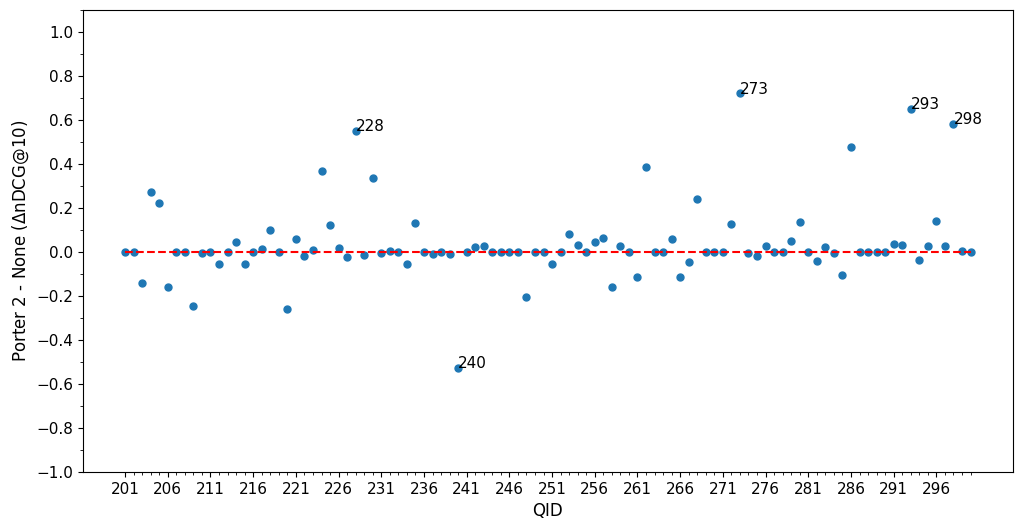

In [218]:
stemmer_a = "porter2"
stemmer_b = "none"
b_list = list()
differences = list()
target = data[data["collectionSize"]==collection_sizes[0]]
for qid in target["qid"].unique().tolist():
    t = target[target["qid"]==qid]
    differences.append(t[t["stemmer"]==stemmer_a]["ndcg"].values[0] - t[t["stemmer"]==stemmer_b]["ndcg"].values[0])
differences = np.array(differences)
unique_qids=np.array(target["qid"].unique().tolist(),dtype=int)
#-----------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(unique_qids,len(unique_qids)*[0],linestyle="dashed",color="red")
plt.scatter(unique_qids,differences,s=25)
plt.xticks(np.arange(min(unique_qids),max(unique_qids),5))
plt.xticks(unique_qids,minor=True)
plt.yticks(np.arange(-1,1.2,0.2))
plt.yticks(np.arange(-1,1.2,0.1),minor=True)
plt.xlabel("QID")
plt.ylabel("Porter 2 - None ($\Delta$nDCG@10)")

for x,y in zip(unique_qids,differences):
    if np.abs(y) > 0.5:
        plt.text(x,y,f"{x}")

plt.show()

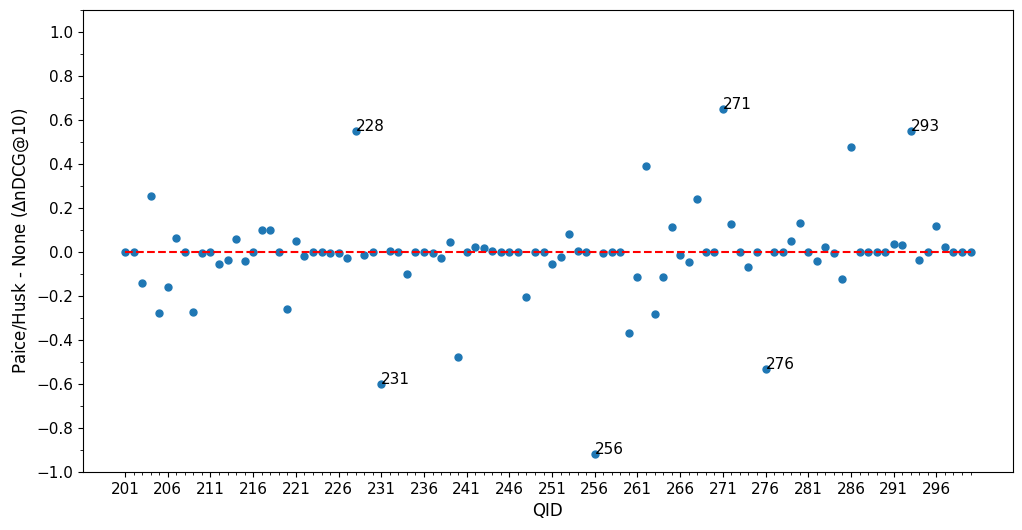

In [217]:
stemmer_a = "paiceHusk"
stemmer_b = "none"
differences = list()
target = data[data["collectionSize"]==collection_sizes[0]]
for qid in target["qid"].unique().tolist():
    t = target[target["qid"]==qid]
    differences.append(t[t["stemmer"]==stemmer_a]["ndcg"].values[0] - t[t["stemmer"]==stemmer_b]["ndcg"].values[0])
differences = np.array(differences)
unique_qids=np.array(target["qid"].unique().tolist(),dtype=int)
#-----------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(unique_qids,len(unique_qids)*[0],linestyle="dashed",color="red")
plt.scatter(unique_qids,differences,s=25)
plt.xticks(np.arange(min(unique_qids),max(unique_qids),5))
plt.xticks(unique_qids,minor=True)
plt.yticks(np.arange(-1,1.2,0.2))
plt.yticks(np.arange(-1,1.2,0.1),minor=True)
plt.xlabel("QID")
plt.ylabel("Paice/Husk - None ($\Delta$nDCG@10)")

for x,y in zip(unique_qids,differences):
    if np.abs(y) > 0.5:
        plt.text(x,y,f"{x}")
        
plt.show()

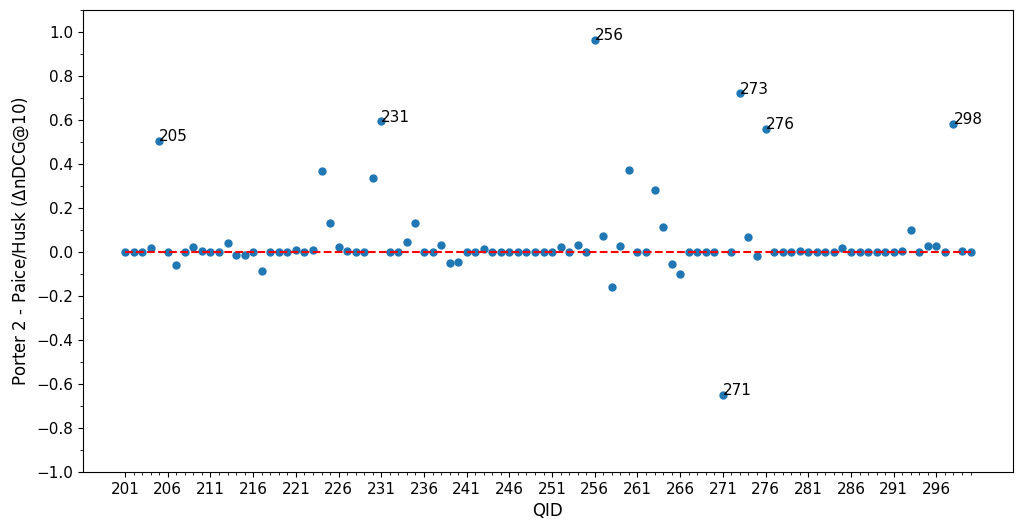

In [216]:
stemmer_a = "porter2"
stemmer_b = "paiceHusk"
differences = list()
target = data[data["collectionSize"]==collection_sizes[0]]
for qid in target["qid"].unique().tolist():
    t = target[target["qid"]==qid]
    differences.append(t[t["stemmer"]==stemmer_a]["ndcg"].values[0] - t[t["stemmer"]==stemmer_b]["ndcg"].values[0])
differences = np.array(differences)
unique_qids=np.array(target["qid"].unique().tolist(),dtype=int)
#-----------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(unique_qids,len(unique_qids)*[0],linestyle="dashed",color="red")
plt.scatter(unique_qids,differences,s=25)
plt.xticks(np.arange(min(unique_qids),max(unique_qids),5))
plt.xticks(unique_qids,minor=True)
plt.yticks(np.arange(-1,1.2,0.2))
plt.yticks(np.arange(-1,1.2,0.1),minor=True)
plt.xlabel("QID")
plt.ylabel("Porter 2 - Paice/Husk ($\Delta$nDCG@10)")

for x,y in zip(unique_qids,differences):
    if np.abs(y) > 0.5:
        plt.text(x,y,f"{x}")

plt.show()